In [1]:
import gzip        
import pickle    
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.signal import find_peaks



In [2]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

In [3]:
def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

# INPUT: TEST VARIABLE + TEST VALUE + FILEPATH

In [4]:
variable = "Decreasing CF -0.01 SCF = 0.2"
value = "15ka"
path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_08_29__12_12_08.pkl.gz"
with gzip.open(path, 'rb') as f:
    DATA_dict = pickle.load(f)



title_GL_basic = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_basic = "Mesh Index"
yaxis_GL_basic = "Timestep (yrs)"

title_GL_better = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_better = "Time (yrs)"
yaxis_GL_better = "Grounding Line Position (km)"

title_GLandVel = "Velocity Comparison to Grounding Line Location: " + variable + " " + value
xaxis_vel = "Distance (km)"
yaxis_vel  = "Velocity (m/yr)"

title_SMB = "Glacier Surface VS Accumulation/Ablation " +  variable + " " + value
xaxis_SMB = "Maximum Accumulation to Maximum Ablation (m/yr)"
yaxis_SMB = ""

title_H = ""
xaxis_H = ""
yaxis_H = ""

title_bed = "Bedrock Erosion Evolution " + variable + " " + value
xaxis_bed = "Distance (km)"
yaxis_bed = "Elevation (m)"

print(title_GL_basic)

Grounding Line Evolution: Decreasing CF -0.01 SCF = 0.2 15ka


## OPENING INDIVIDUAL DICTIONARIES

In [5]:
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']
final_time = list(GL_dict)[-1]
print(final_time)


15000.47235674344


## BASIC GL PLOT

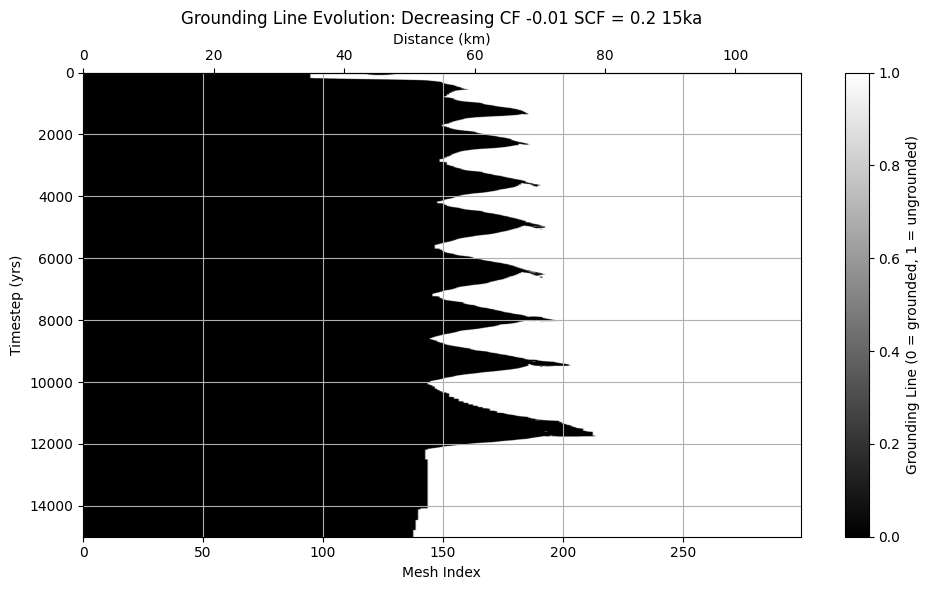

In [6]:
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)
ax.set_ylabel(yaxis_GL_basic)
ax.set_xlabel(xaxis_GL_basic)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(title_GL_basic)
# ax.set_ylim(10000)


# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.grid()
plt.show()

## BETTER GL PLOT

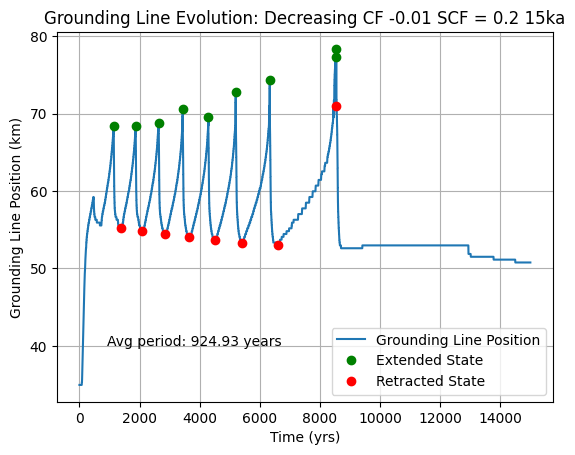

Mean cycle period: 924.93 years
[ 731.17664818  765.35723967  801.83053734  850.85569445  914.17286046
 1131.88562473 2191.48989641   12.70173372]
Mean advance amplitude: 72.07 km
[68.42809365 68.42809365 68.79598662 70.63545151 69.53177258 72.84280936
 74.31438127 77.25752508 78.36120401]
Mean retreat amplitude: 56.20 km
[55.18394649 54.81605351 54.44816054 54.08026756 53.71237458 53.34448161
 52.97658863 71.00334448]


In [7]:
fig, ax = plt.subplots()

gl_positions = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions.append(idx)

gl_positions = np.array(gl_positions)
GL_km = mesh_index_to_km(gl_positions)

peaks, _ = find_peaks(GL_km, prominence=5) 
troughs, _ = find_peaks(-GL_km, prominence=5)     
periods = np.diff(np.array(time)[peaks])
adv_dists = GL_km[peaks]
ret_dists = GL_km[troughs]


plt.plot(time, GL_km, label='Grounding Line Position')
plt.plot(np.array(time)[peaks], GL_km[peaks], 'go', label='Extended State')
plt.plot(np.array(time)[troughs], GL_km[troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
# plt.xlim(0,10000)
plt.xlabel(xaxis_GL_better)
plt.ylabel(yaxis_GL_better)
plt.title(title_GL_better )
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods):.2f} years")
print(periods)

print(f"Mean advance amplitude: {np.mean(adv_dists):.2f} km")
print(adv_dists)

print(f"Mean retreat amplitude: {np.mean(ret_dists):.2f} km")
print(ret_dists)



### Pulling Velocity Data

In [8]:
term_surface_velocity = []
term_basal_velocity = []

for t in sorted(us_dict.keys()): 
    us_ = us_dict[t]
    ub_ = ub_dict[t]

    notNAN = np.where(np.isfinite(us_))[0]

    if len(notNAN) > 0:
        terminus = notNAN[-1]
    else:
        terminus = None

    if terminus is not None and terminus >= 50:
        term_usvel = us_[terminus - 50]
        term_ubvel = ub_[terminus - 50]
    else:
        term_usvel = 0
        term_ubvel = 0

    if np.isnan(term_usvel):
        term_usvel = 0
    if np.isnan(term_ubvel):
        term_ubvel = 0

    term_surface_velocity.append(term_usvel)
    term_basal_velocity.append(term_ubvel)

## VELOCITY OVER GL PLOT

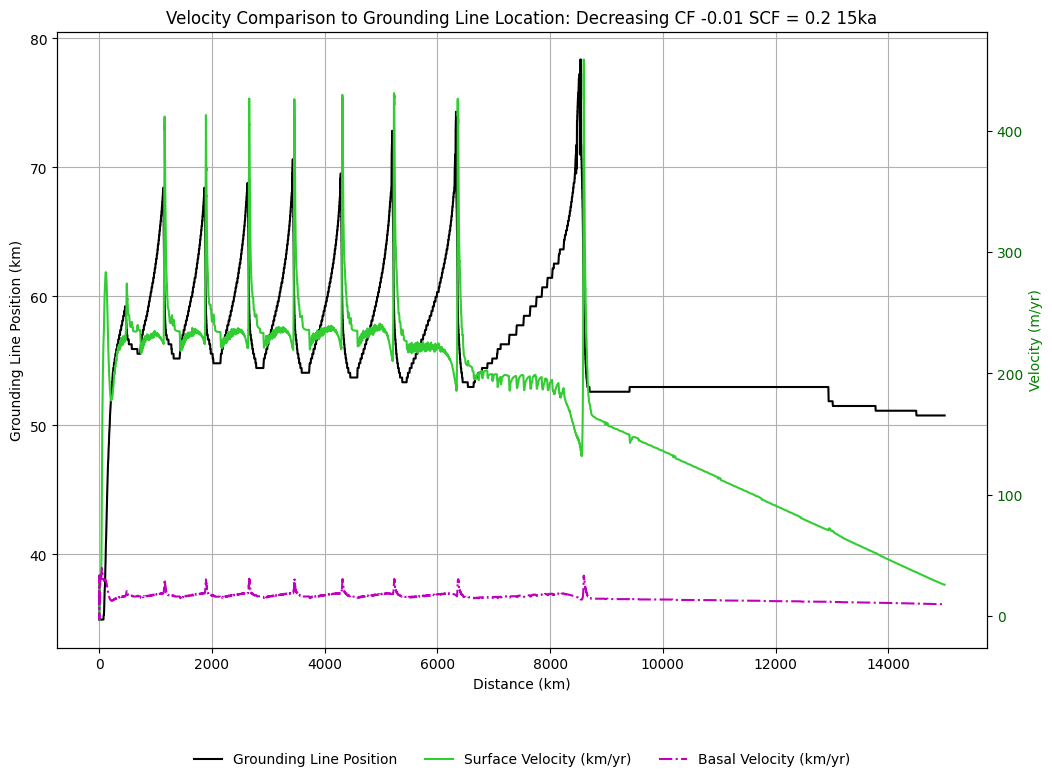

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Velocity
ax2 = ax1.twinx()
ax2.plot(time, term_surface_velocity, 'limegreen',  label='Surface Velocity (km/yr)')
ax2.plot(time, term_basal_velocity, 'm-.', label='Basal Velocity (km/yr)')
ax2.set_ylabel(yaxis_vel, color='green')
ax2.tick_params(axis='y', labelcolor='darkgreen')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.title(title_GLandVel)
plt.show()


## BED ELEVATION CHANGE PLOT

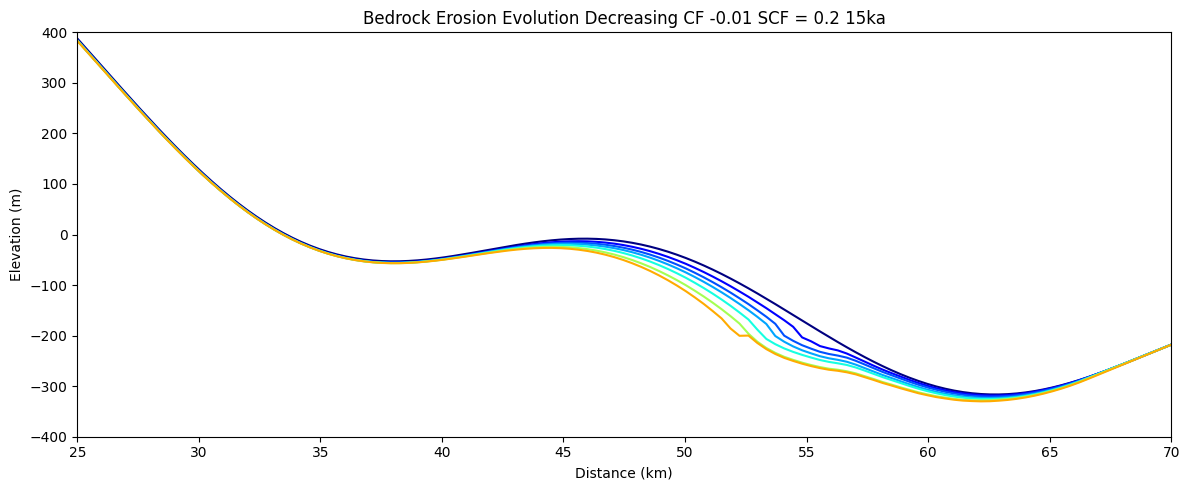

In [10]:
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(12,5))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel(xaxis_bed)
plt.ylabel(yaxis_bed)
plt.title(title_bed)
# plt.gca().invert_xaxis() 
# plt.legend(loc="upper right", fontsize=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(25,70)
plt.ylim(-400,400)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/20kTests/40K_Base_test/blah.svg", format ="svg", bbox_inches='tight')

## SMB PLOT

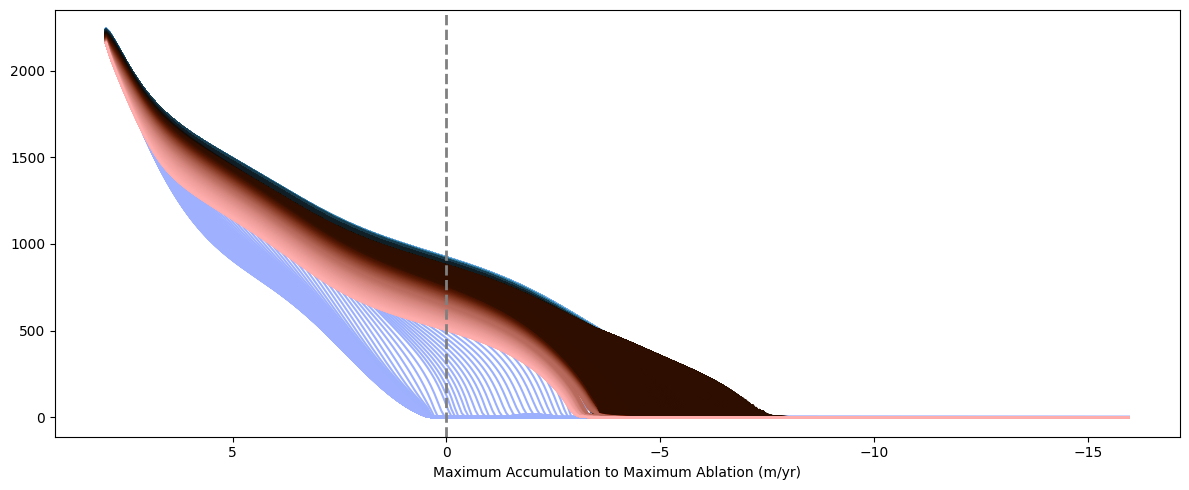

[ 0.4776  0.4728  0.468   0.4632  0.4584  0.4536  0.4488  0.444   0.4392
  0.4344  0.4296  0.4248  0.42    0.4152  0.4104  0.4056  0.4008  0.396
  0.3912  0.3864  0.3816  0.3768  0.372   0.3672  0.3624  0.3576  0.3528
  0.348   0.3432  0.3384  0.3336  0.3288  0.324   0.3192  0.3144  0.3096
  0.3048  0.3     0.2952  0.2904  0.2856  0.2808  0.276   0.2712  0.2664
  0.2616  0.2568  0.252   0.2472  0.2424  0.2376  0.2328  0.228   0.2232
  0.2184  0.2136  0.2088  0.204   0.1992  0.1944  0.1896  0.1848  0.18
  0.1752  0.1704  0.1656  0.1608  0.156   0.1512  0.1464  0.1416  0.1368
  0.132   0.1272  0.1224  0.1176  0.1128  0.108   0.1032  0.0984  0.0936
  0.0888  0.084   0.0792  0.0744  0.0696  0.0648  0.06    0.0552  0.0504
  0.0456  0.0408  0.036   0.0312  0.0264  0.0216  0.0168  0.012   0.0072
  0.0024 -0.0024 -0.0072 -0.012  -0.0168 -0.0216 -0.0264 -0.0312 -0.036
 -0.0408 -0.0456 -0.0504 -0.0552 -0.06   -0.0648 -0.0696 -0.0744 -0.0792
 -0.084  -0.0888 -0.0936 -0.0984 -0.1032 -0.108  -0.112

In [18]:
timesteps = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timesteps[0]] 
cmap = cm.berlin

fig,ax  = plt.subplots(figsize=(12,5))


counts = sorted(counter_dict.values())  # all loop counts
sample_counts = counts[::1] 

# make a lookup: loop count → time
loop_to_time = {v: k for k, v in counter_dict.items()}

for j, c in enumerate(sample_counts):
    t = loop_to_time[c]
    surf = surf_dict[t]
    color = cmap(norm(t))
    label = f't={t:.1f}' if j % 5 == 0 else ""
    plt.plot(smb_profile, surf, color=color, label=label)


plt.xlabel(xaxis_SMB)
plt.ylabel(yaxis_SMB)
# plt.title(title_SMB)
plt.gca().invert_xaxis()
# plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SMB_plot_40k_default.svg", format ="svg", bbox_inches='tight')

final_smb = list(SMB_dict.values())[-1]
print(final_smb)

## Plotting Thickness

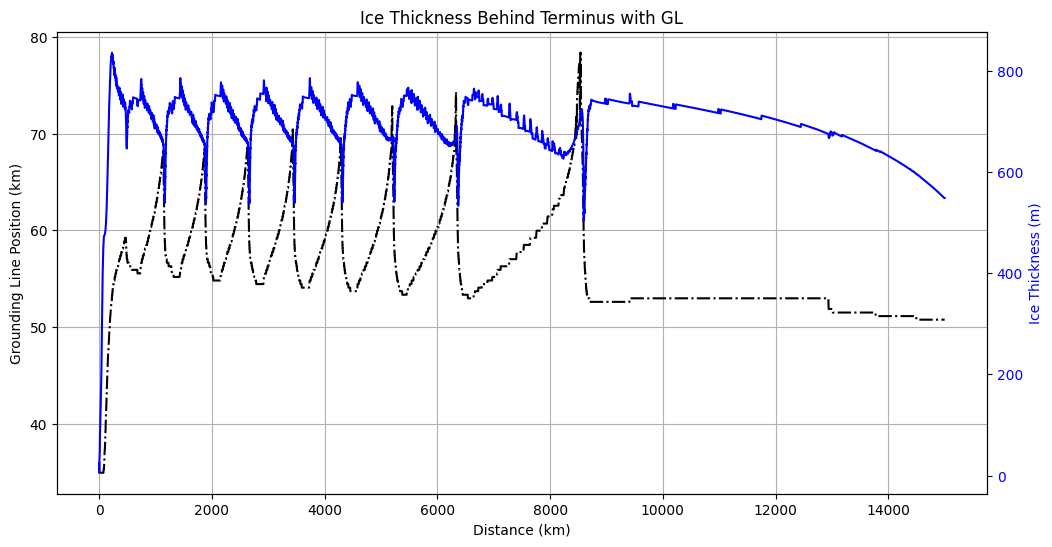

In [12]:
term_thinning = []
dist_behind_terminus = 50
time_steps = sorted(H_dict.keys())

for t in time_steps:
    H_ = H_dict[t]

    terminus_indices = np.where(H_ > 1.0)[0]

    if len(terminus_indices) == 0:
        term_thinning.append(np.nan)
        continue

    terminus = terminus_indices[-1]

    if terminus >= dist_behind_terminus:
        term_H = H_[terminus - dist_behind_terminus]
    else:
        term_H = np.nan

    term_thinning.append(term_H)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time, GL_km, label='Grounding Line Position', ls = 'dashdot', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
# ax1.set_xlim(2000,8000)
ax1.grid()

# Secondary axis for velocities
ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Thickness {dist_behind_terminus} nodes behind terminus')
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Ice Thickness Behind Terminus with GL")
plt.show()

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/20kTests/40K_Base_test/Thickness_plot_40k_default.svg", format ="svg", bbox_inches='tight')

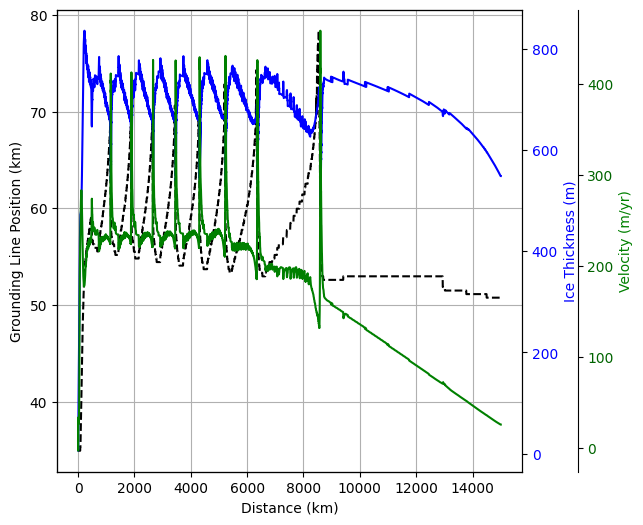

In [13]:
fig, ax1 = plt.subplots(figsize=(6, 6))

# Grounding Line Position
ax1.plot(time, GL_km, label='Grounding Line Position', ls='--', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
# ax1.set_xlim(3000, 5000)
ax1.grid()

# Ice Thickness behind terminus
ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Thickness {dist_behind_terminus} nodes behind terminus')
ax2.set_ylabel("Ice Thickness (m)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Surface Velocity — create new axis and offset it to avoid overlapping ax2
ax3 = ax1.twinx()
ax3.plot(time, term_surface_velocity, 'green', ls='-', label='Surface Velocity (km/yr)')
ax3.set_ylabel(yaxis_vel, color='green')
ax3.tick_params(axis='y', labelcolor='darkgreen')

# Offset ax3's spine to the right to prevent overlapping ax2
ax3.spines["right"].set_position(("axes", 1.12))  # 10% to the right of the ax1 right spine
ax3.spines["right"].set_visible(True)  # Make sure it's visible

# Title and show
# plt.title("Sample Cycle from Default")
plt.show()

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/SingleCycle.svg", format ="svg", bbox_inches='tight')


## Velocity VS Thickness


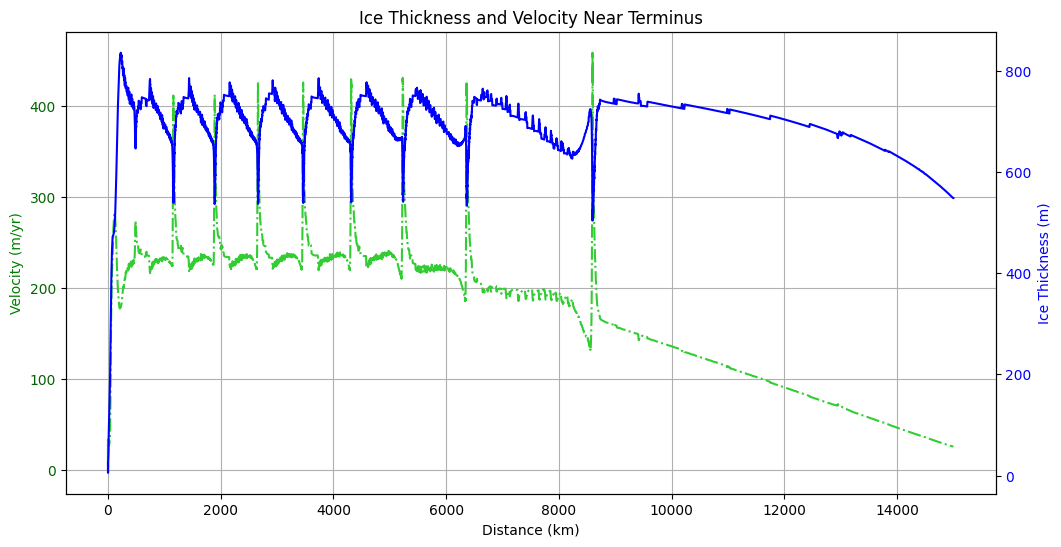

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time, term_surface_velocity, 'limegreen', ls = '-.', label='Surface Velocity (km/yr)')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_vel, color='green')
ax1.tick_params(axis='y', labelcolor='darkgreen')
# ax1.set_xlim(0,10000)
ax1.grid()


ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Thickness {dist_behind_terminus} nodes behind terminus')
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.title("Ice Thickness and Velocity Near Terminus")
plt.show()

In [15]:
vel_peaks, _ = find_peaks(term_surface_velocity, prominence=5) 
H_peaks, _ = find_peaks(term_thinning, prominence=5)     

Text(0, 0.5, 'Near Terminus Surface Velocity')

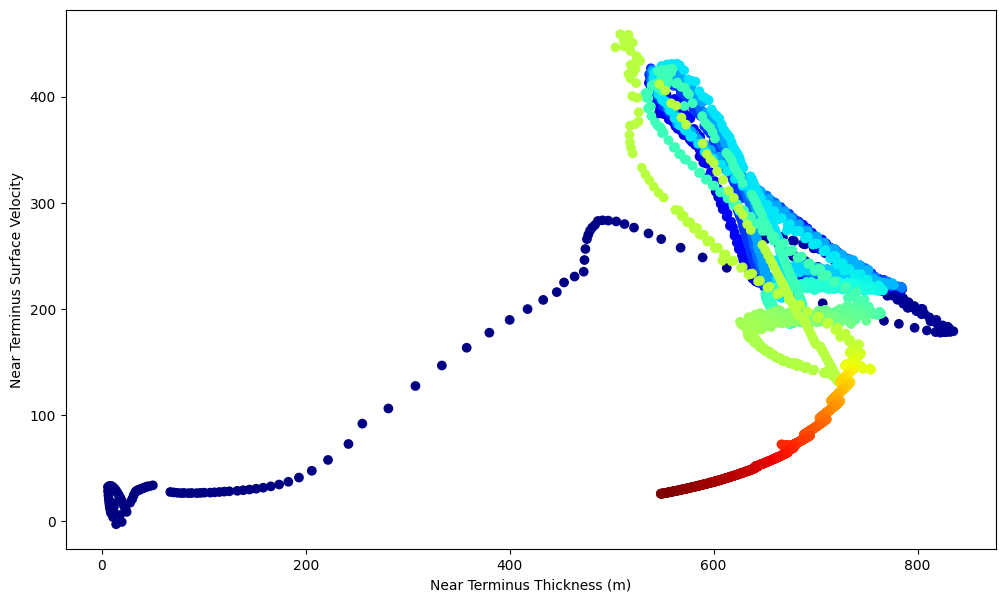

In [16]:
fig,ax = plt.subplots(figsize = (12,7))
plt.scatter(term_thinning, term_surface_velocity, c = time, cmap = 'jet')
plt.xlabel("Near Terminus Thickness (m)")
plt.ylabel("Near Terminus Surface Velocity")

In [17]:
print(np.size(vel_peaks))
print(np.size(H_peaks))

102
208
